In [19]:
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial

from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix




key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 1.0    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


In [20]:
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations

In [21]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost


In [36]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
print(K[-1])
K_steady = K[-1]

[[ 8.5351974e-01 -1.5736137e-03  3.2620798e-03 ...  1.2708447e-04
   1.6275395e-03  1.7243569e-03]
 [-1.5736170e-03  8.5684448e-01  1.8644118e-03 ...  5.0668423e-05
   2.3030170e-04 -1.9055177e-03]
 [ 3.2620861e-03  1.8644118e-03  8.5432827e-01 ... -1.6230506e-05
   2.5125028e-04  8.1682199e-04]
 ...
 [ 1.2708428e-04  5.0668383e-05 -1.6230490e-05 ...  8.5216057e-01
  -2.4127385e-03 -1.0112927e-03]
 [ 1.6275443e-03  2.3030123e-04  2.5125055e-04 ... -2.4127348e-03
   8.5423237e-01  7.7353022e-03]
 [ 1.7243616e-03 -1.9055187e-03  8.1681961e-04 ... -1.0112919e-03
   7.7353055e-03  8.5352236e-01]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm

var_cost_grad = grad(var_cost, argnums=0)

# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4
alpha = 1e-5


prediction_errors = [] 
errs = []

for i in tqdm(range(100)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, H, Q, R, y, key, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, _ = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
    
    prediction_error = jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    errs.append(jnpl.norm(K_opt - K_steady))

NameError: name 'grad' is not defined

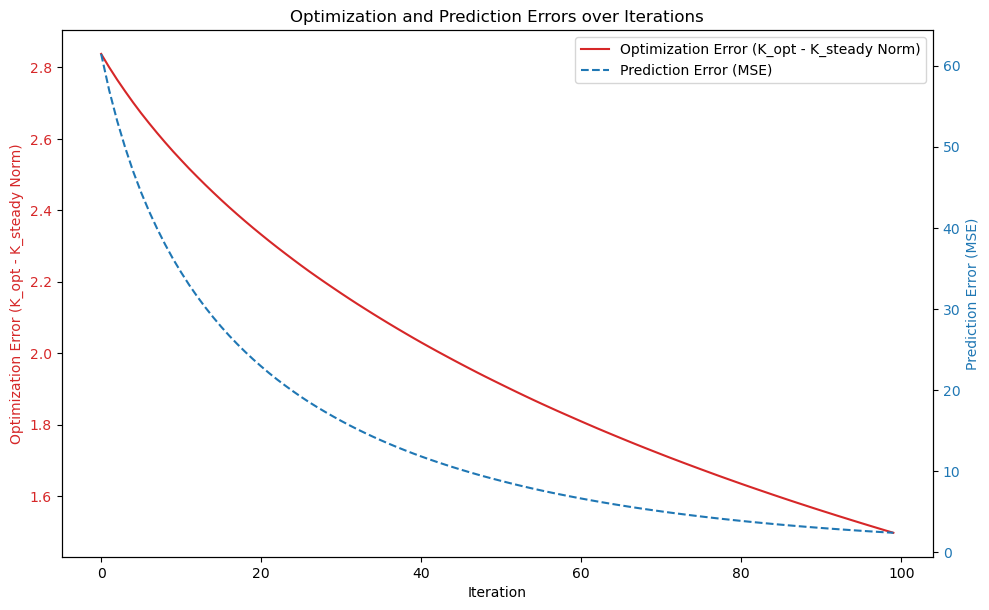

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Optimization Error (K_opt - K_steady Norm)', color=color)
ax1.plot(errs, label='Optimization Error (K_opt - K_steady Norm)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Prediction Error (MSE)', color=color)
ax2.plot(prediction_errors, label='Prediction Error (MSE)', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
fig.tight_layout()
plt.title('Optimization and Prediction Errors over Iterations')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [24]:
import jax
import jax.numpy as jnp
from jax import lax

def kalman_step(state, observation, params):
    m_prev, C_prev = state
    state_transition_function, jacobian_function, H, Q, R = params
    m_pred = state_transition_function(m_prev)
    F_jac = jacobian_function(m_prev)
    C_pred = F_jac @ C_prev @ F_jac.T + Q
    S = H @ C_pred @ H.T + R
    K_curr = C_pred @ H.T @ jnp.linalg.inv(S)
    m_update = m_pred + K_curr @ (observation - H @ m_pred)
    C_update = (jnp.eye(H.shape[1]) - K_curr @ H) @ C_pred
    
    return (m_update, C_update), (m_update, C_update, K_curr)

def kalman_filter_process(state_transition_function, jacobian_function, m0, C0, observations, H, Q, R):
    n = m0.shape[0]
    num_steps = observations.shape[0]
    params = (state_transition_function, jacobian_function, H, Q, R)
    initial_state = (m0, C0)

    # Execute `lax.scan` over the sequence of observations
    _, (m, C, K) = lax.scan(lambda state, obs: kalman_step(state, obs, params),
                            initial_state, observations)
    
    return m, C, K



[[ 8.5351974e-01 -1.5736137e-03  3.2620798e-03 ...  1.2708447e-04
   1.6275395e-03  1.7243569e-03]
 [-1.5736170e-03  8.5684448e-01  1.8644118e-03 ...  5.0668423e-05
   2.3030170e-04 -1.9055177e-03]
 [ 3.2620861e-03  1.8644118e-03  8.5432827e-01 ... -1.6230506e-05
   2.5125028e-04  8.1682199e-04]
 ...
 [ 1.2708428e-04  5.0668383e-05 -1.6230490e-05 ...  8.5216057e-01
  -2.4127385e-03 -1.0112927e-03]
 [ 1.6275443e-03  2.3030123e-04  2.5125055e-04 ... -2.4127348e-03
   8.5423237e-01  7.7353022e-03]
 [ 1.7243616e-03 -1.9055187e-03  8.1681961e-04 ... -1.0112919e-03
   7.7353055e-03  8.5352236e-01]]
